# Importing the Libraries

In [417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the dataset

In [418]:
dataset = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')

In [419]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [420]:
dataset.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [421]:
dataset.shape

(41188, 21)

### Determining the number of missing values

In [422]:
dataset.isin(['unknown']).sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [423]:
dataset_copy = dataset.copy()

In [424]:
def change_column_type_object_to_categorical(df):
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    for column in object_columns:
        df[column] = pd.Categorical(df[column])

In [425]:
change_column_type_object_to_categorical(dataset_copy)
dataset_copy.dtypes

age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
y                 category
dtype: object

### Reordering the columns order as numerical to categorical

In [426]:
# Separate numerical and categorical columns
numerical_columns = dataset_copy.select_dtypes(include='number').columns.tolist()
categorical_columns = dataset_copy.select_dtypes(exclude='number').columns.tolist()

# Reorder columns
new_order = numerical_columns + categorical_columns
dataset_copy = dataset_copy[new_order]
dataset_copy.dtypes

age                  int64
duration             int64
campaign             int64
pdays                int64
previous             int64
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
poutcome          category
y                 category
dtype: object

# Exploring the dataset

In [427]:
def visualize_features(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, kde=True, color='skyblue')
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [428]:
def visualize_target_feature(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, hue='y', multiple='stack', palette='Set2')
    plt.title(f"Distribution of 'y' within {column_name} Groups")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [429]:
def visualize_outliers(df, column_name):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=column_name, color='skyblue')
    plt.title(f"Boxplot of {column_name} (with Outliers)")
    plt.xlabel(column_name)
    plt.tight_layout()
    plt.show()

In [430]:
def visualize(df,column_name):
    visualize_features(df,column_name)
    visualize_target_feature(df,column_name)
    visualize_outliers(df, column_name)

In [431]:
def remove_outliers_by_quantiles(df, column_name, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = df[column_name].quantile(lower_quantile)
    upper_bound = df[column_name].quantile(upper_quantile)
    df.drop(df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index, inplace=True)

In [432]:
def extract_feature_by_thresholds(df,col_name,thresholds):
    labels = []
    for i in range(len(thresholds) - 1):
        label = f"{col_name}_({thresholds[i]}_{thresholds[i+1]}]"
        mask = (df[col_name] > thresholds[i]) & (df[col_name] <= thresholds[i+1])
        df.loc[mask, f'{col_name}_group'] = label
        labels.append(label)

In [433]:
def print_extract_feature_by_thresholds(df,col_name,thresholds):
    percentages = {}
    total_samples = len(df)
    for i in range(len(thresholds) - 1):
        lower_bound = thresholds[i]
        upper_bound = thresholds[i + 1]
        mask = (df[col_name] > lower_bound) & (df[col_name] <= upper_bound)
        count = df.loc[mask].shape[0]
        percentage = (count / total_samples)
        rounded_percentage = round(percentage, 4)
        print(f"({lower_bound}_{upper_bound}] = {rounded_percentage}, samples:{count}")

In [434]:
def calculate_success_rate(df, feature_column, target_column, lower_bound,upper_bound):
    # Filter the DataFrame for the specific condition
    filtered_df = df[(df[feature_column] >= lower_bound) & (df[feature_column] <= upper_bound)].copy()
    # Group by the feature column and calculate the rate of 'yes' for each unique value
    grouped = filtered_df.groupby(feature_column)[target_column].apply(lambda x: (x == 'yes').mean())
    success_rate = grouped.mean()
    return grouped, success_rate


In [435]:
def generate_start_end_threshold(df, col_name, increment_range):
    start = df[col_name].min() - (df[col_name].min())%increment_range
    end = df[col_name].max() - (df[col_name].max())%increment_range + increment_range
    return start, end

In [436]:
def generate_threshold(df,col_name,increment_range):
    start, end = generate_start_end_threshold(df,col_name,increment_range)
    thresholds = []
    threshold = start
    while threshold <= end:
        thresholds.append(threshold)
        threshold += increment_range
    return thresholds


#### Exploring the numerical columns

##### 1-) "Age"

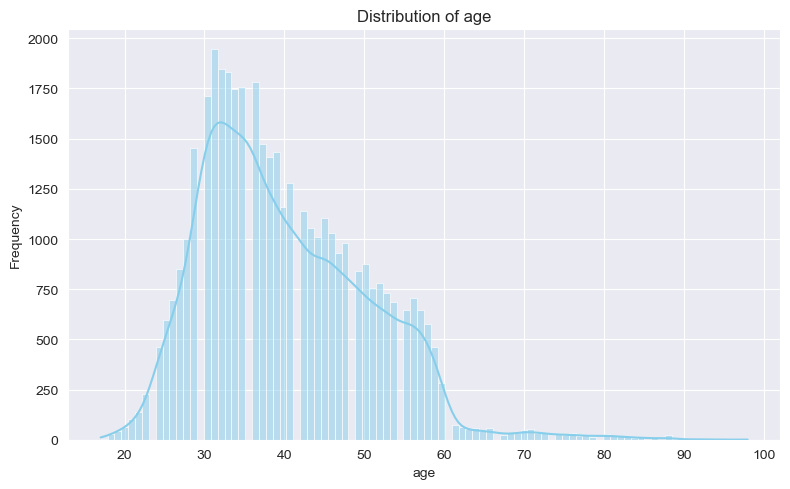

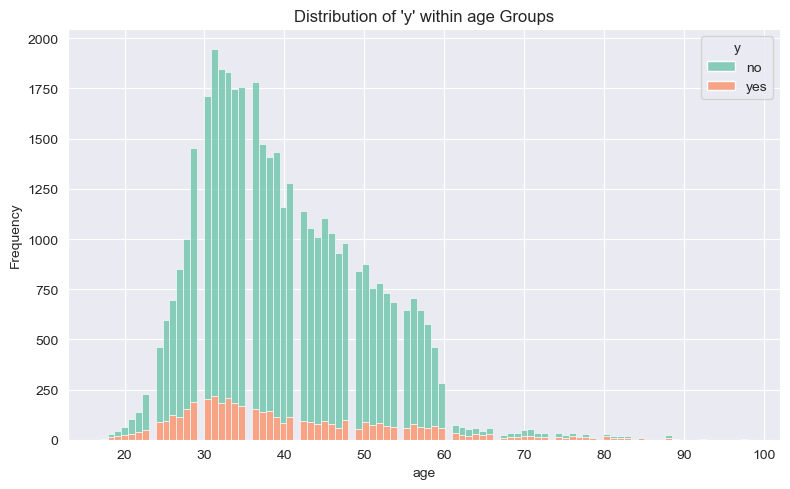

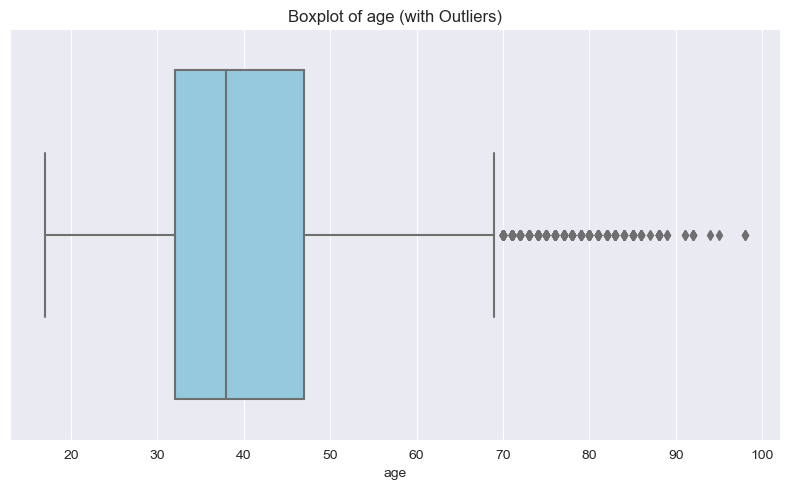

In [437]:
visualize(dataset_copy,'age')

In [438]:
remove_outliers_by_quantiles(dataset_copy,'age')

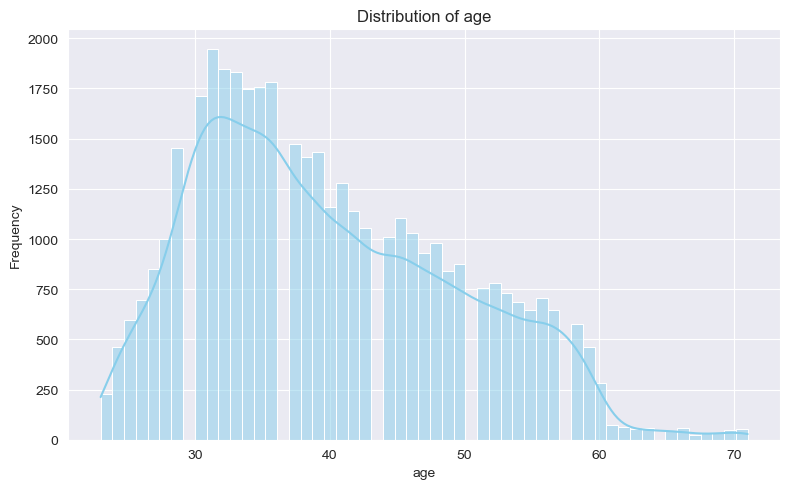

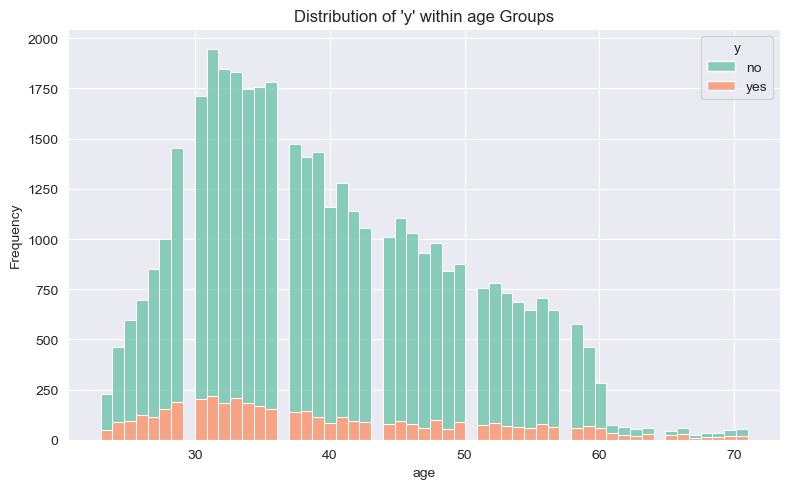

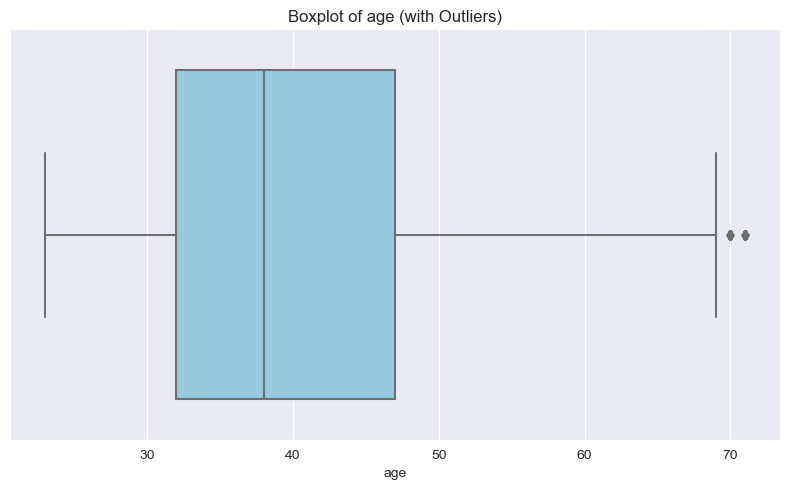

In [439]:
visualize(dataset_copy,'age')

In [440]:
age_threshold = generate_threshold(dataset_copy,'age',5)
print(age_threshold)

[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


In [441]:
print_extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

(20_25] = 0.0318, samples:1287
(25_30] = 0.1414, samples:5717
(30_35] = 0.2258, samples:9130
(35_40] = 0.1794, samples:7255
(40_45] = 0.1382, samples:5589
(45_50] = 0.115, samples:4651
(50_55] = 0.089, samples:3598
(55_60] = 0.0661, samples:2672
(60_65] = 0.0072, samples:291
(65_70] = 0.0049, samples:197
(70_75] = 0.0013, samples:53


In [442]:
extract_feature_by_thresholds(dataset_copy,'age',age_threshold)
dataset_copy['age_group'].value_counts()

age_group
age_(30_35]    9130
age_(35_40]    7255
age_(25_30]    5717
age_(40_45]    5589
age_(45_50]    4651
age_(50_55]    3598
age_(55_60]    2672
age_(20_25]    1287
age_(60_65]     291
age_(65_70]     197
age_(70_75]      53
Name: count, dtype: int64

##### 2-) "Duration"

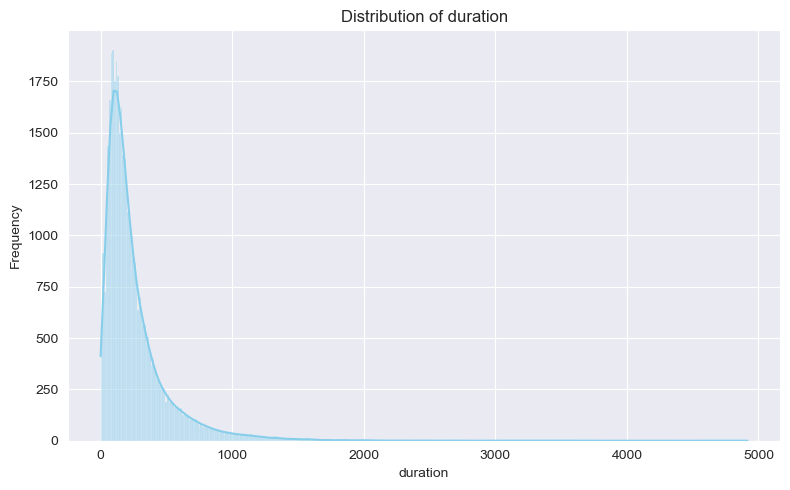

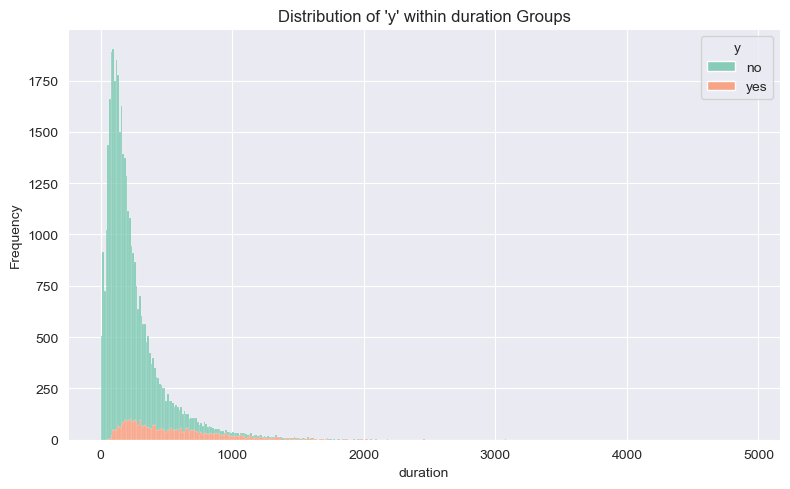

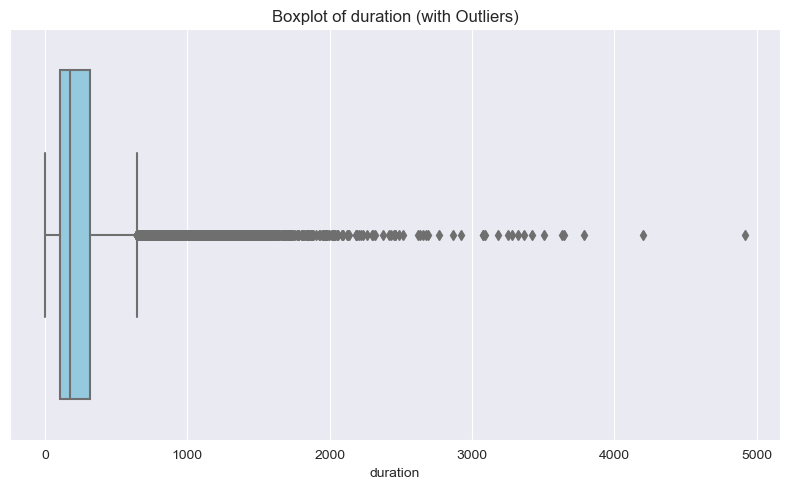

In [443]:
visualize(dataset_copy,'duration')

In [444]:
remove_outliers_by_quantiles(dataset_copy,'duration')

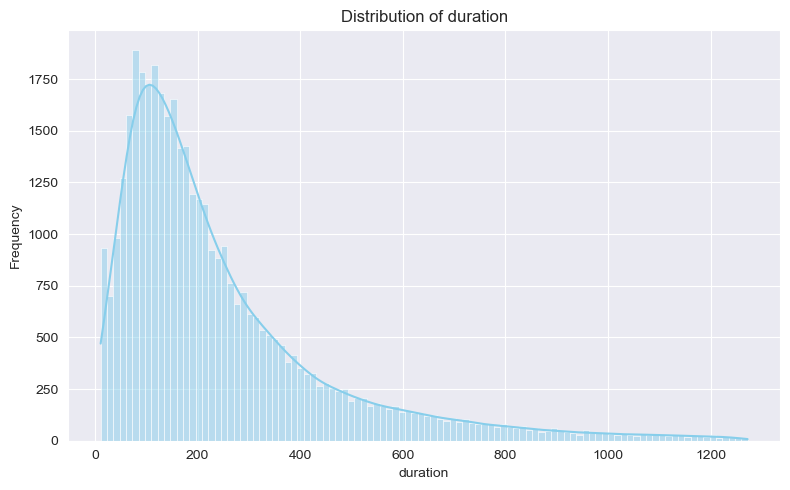

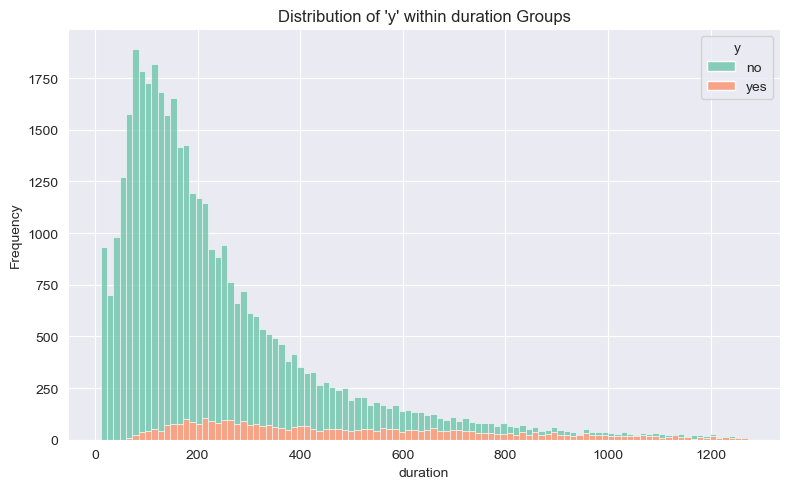

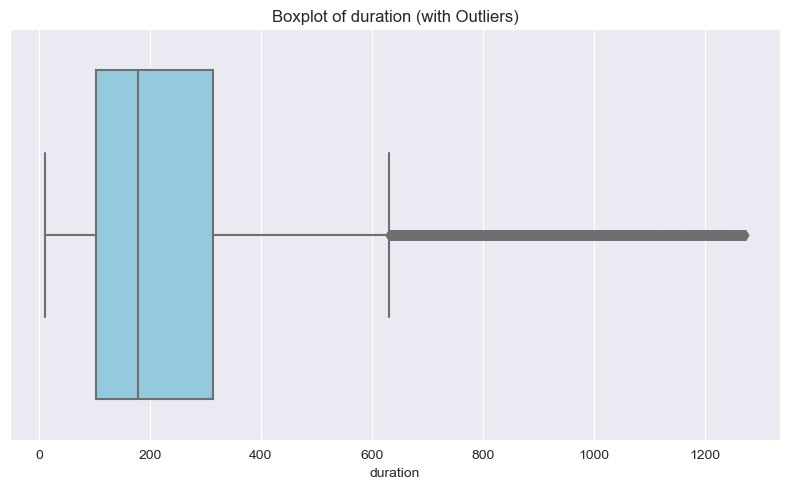

In [445]:
visualize(dataset_copy,'duration')

In [446]:
duration_threshold = generate_threshold(dataset_copy,'duration',100)
print(duration_threshold)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300]


In [447]:
print_extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

(0_100] = 0.2407, samples:9549
(100_200] = 0.3148, samples:12492
(200_300] = 0.1778, samples:7056
(300_400] = 0.0996, samples:3952
(400_500] = 0.0553, samples:2196
(500_600] = 0.0361, samples:1432
(600_700] = 0.0251, samples:996
(700_800] = 0.0172, samples:682
(800_900] = 0.0117, samples:465
(900_1000] = 0.0081, samples:321
(1000_1100] = 0.0063, samples:248
(1100_1200] = 0.0047, samples:186
(1200_1300] = 0.0026, samples:103


In [448]:
extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)
dataset_copy['duration_group'].value_counts()

duration_group
duration_(100_200]      12492
duration_(0_100]         9549
duration_(200_300]       7056
duration_(300_400]       3952
duration_(400_500]       2196
duration_(500_600]       1432
duration_(600_700]        996
duration_(700_800]        682
duration_(800_900]        465
duration_(900_1000]       321
duration_(1000_1100]      248
duration_(1100_1200]      186
duration_(1200_1300]      103
Name: count, dtype: int64

##### 3-) "Campaign"

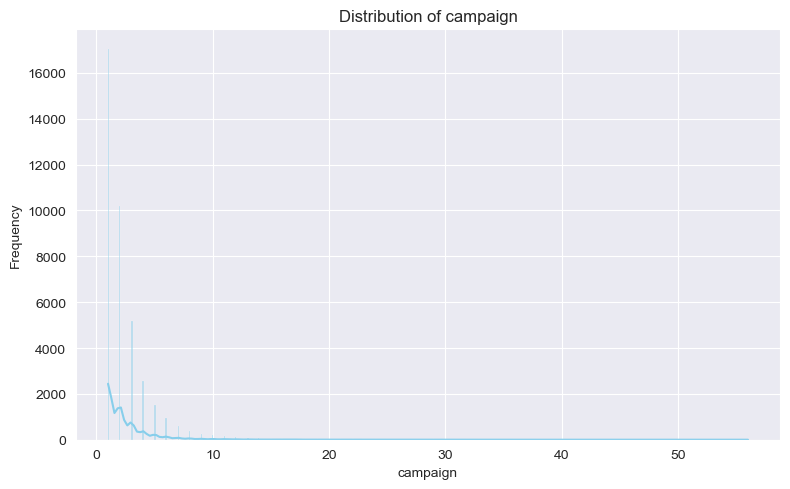

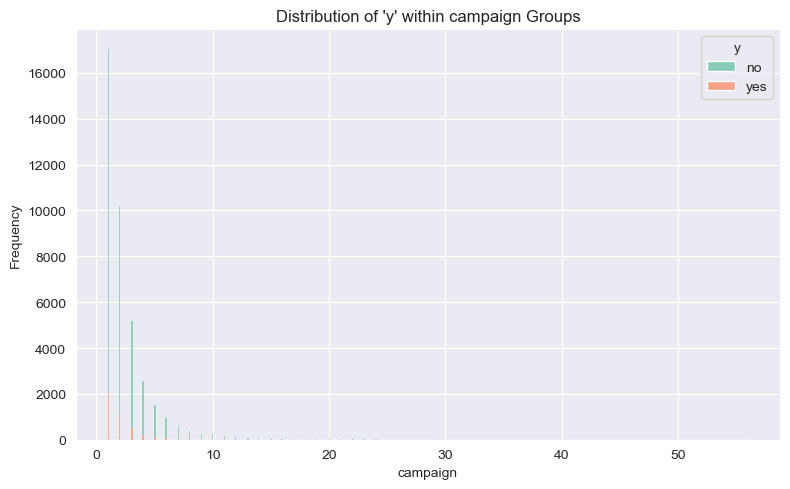

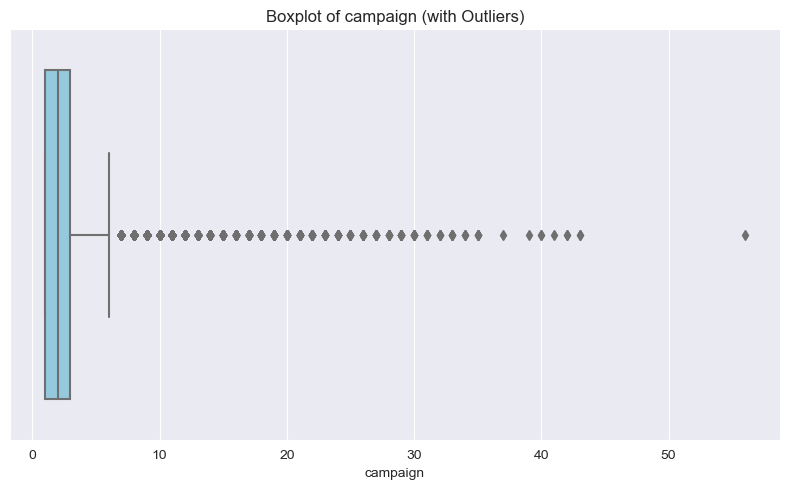

In [449]:
visualize(dataset_copy,'campaign')

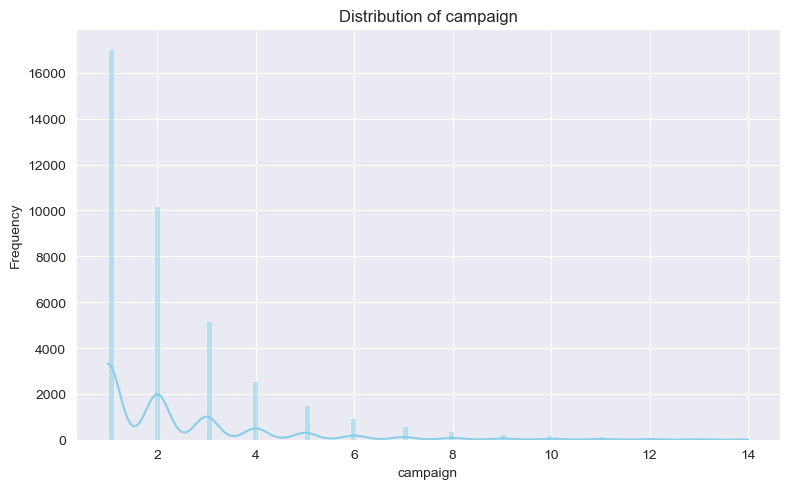

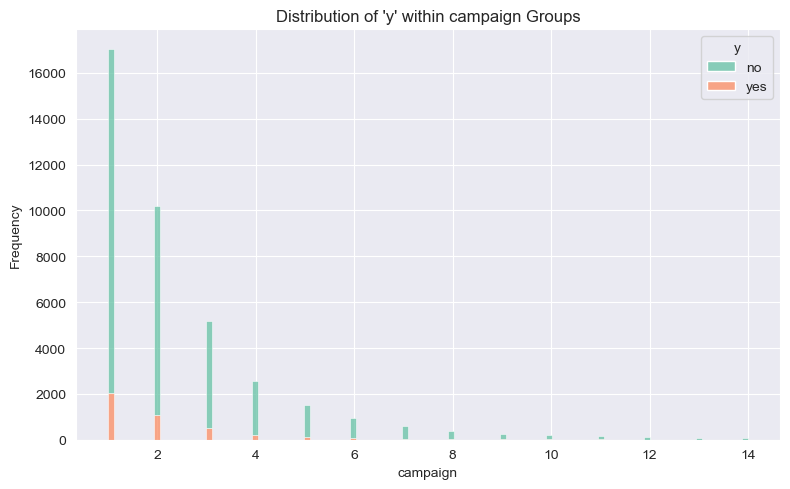

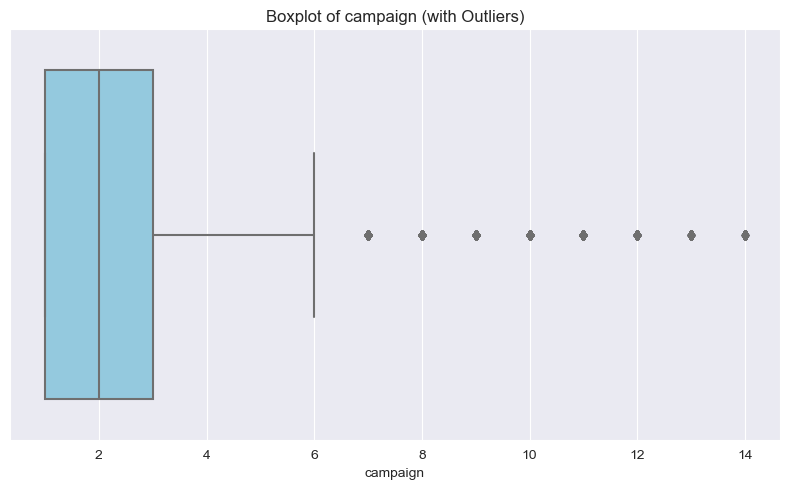

In [450]:
remove_outliers_by_quantiles(dataset_copy,'campaign')
visualize(dataset_copy,'campaign')

##### 4-) "pdays"

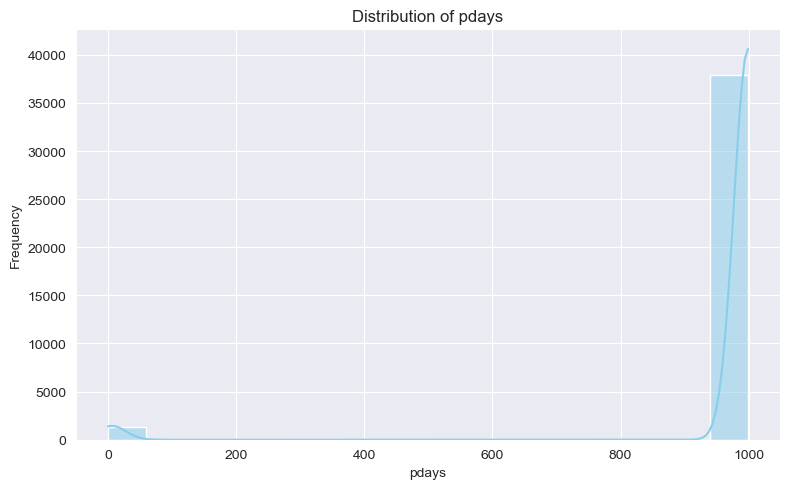

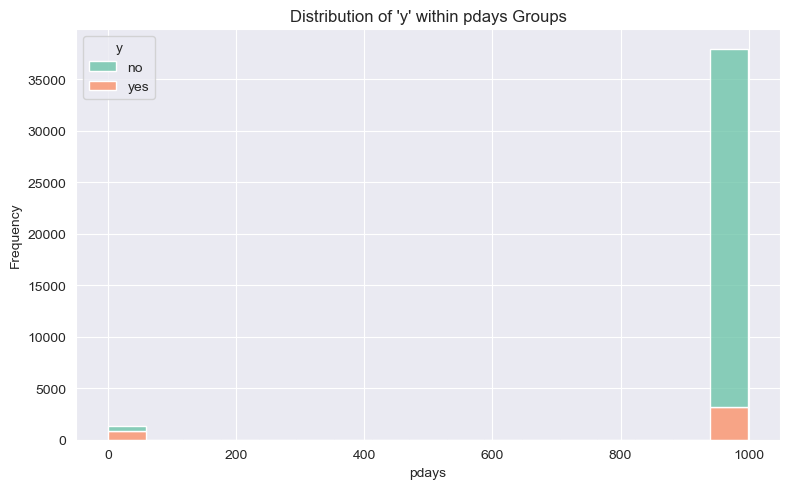

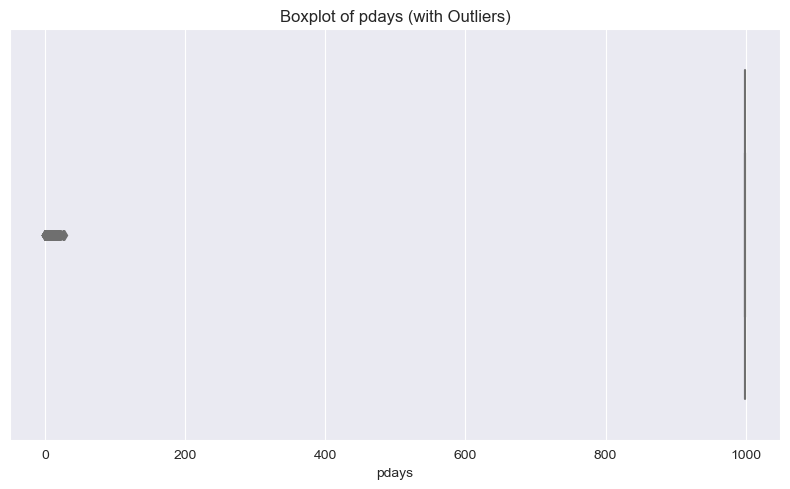

In [451]:
visualize(dataset_copy,'pdays')

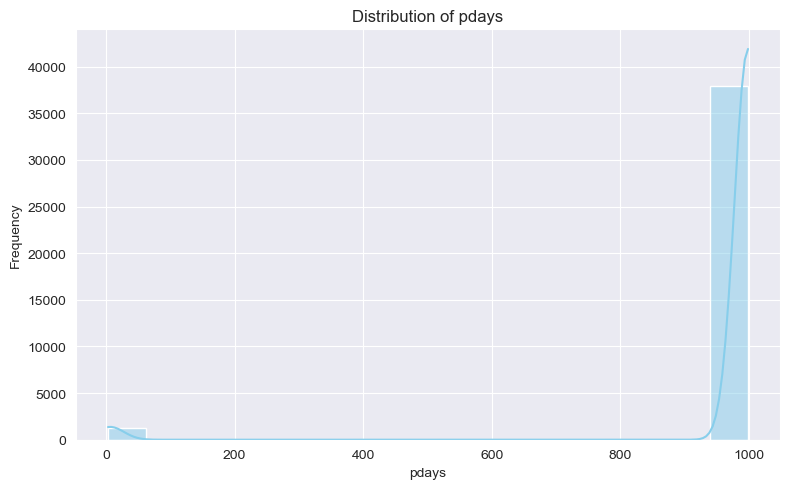

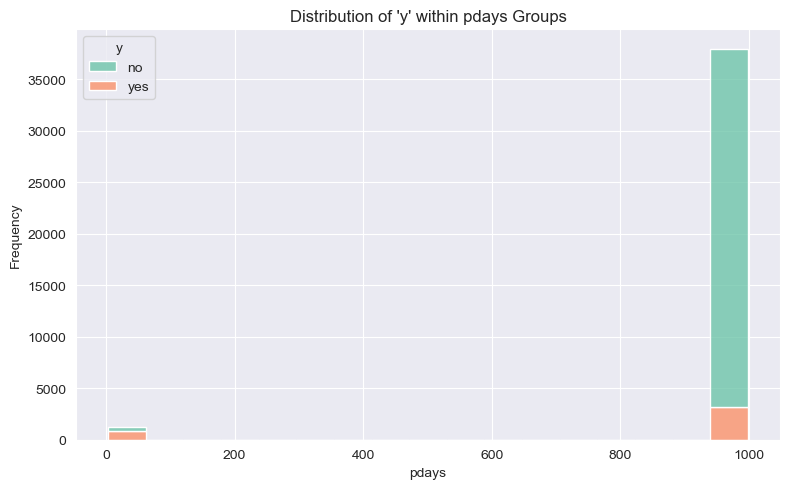

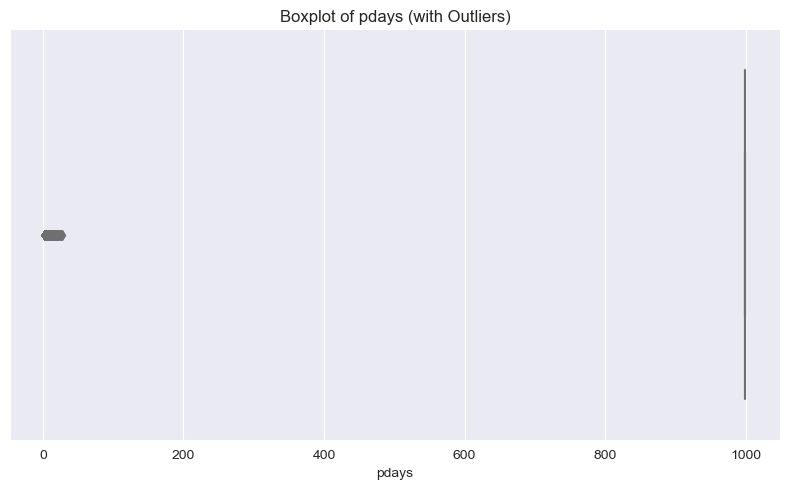

In [452]:
remove_outliers_by_quantiles(dataset_copy,'pdays')
visualize(dataset_copy,'pdays')

In [453]:
dataset_copy['pdays'].value_counts()

pdays
999    37942
3        388
6        368
4        107
9         58
7         52
12        51
10        50
5         43
13        31
11        28
15        22
14        18
8         16
16        10
17         7
18         7
22         3
21         2
19         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

In [454]:
dataset_copy['pdays_group'] = dataset_copy['pdays']
dataset_copy.loc[dataset_copy['pdays'] <= 100, 'pdays_group'] = 0
dataset_copy.loc[dataset_copy['pdays'] > 100, 'pdays_group'] = 1

In [455]:
dataset_copy['pdays_group'].value_counts()

pdays_group
1    37942
0     1267
Name: count, dtype: int64

##### 5-) "previous"

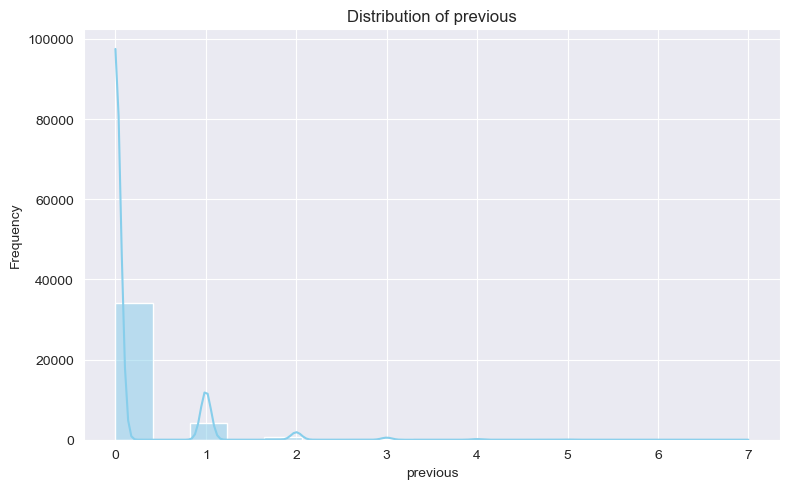

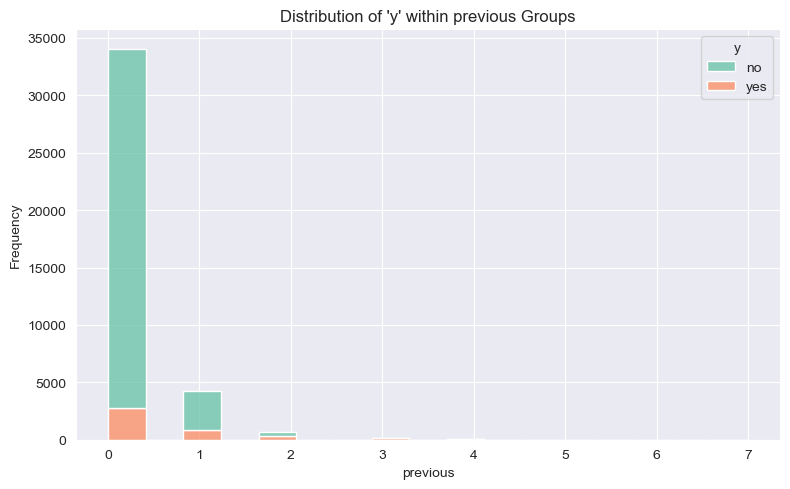

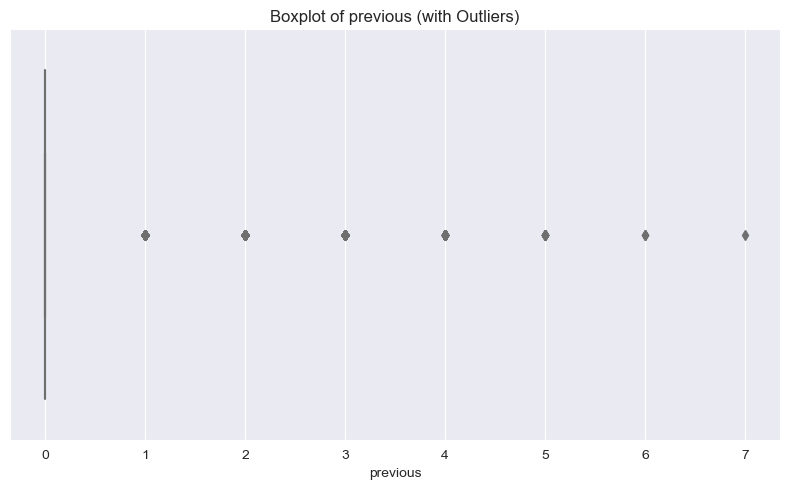

In [456]:
visualize(dataset_copy,'previous')

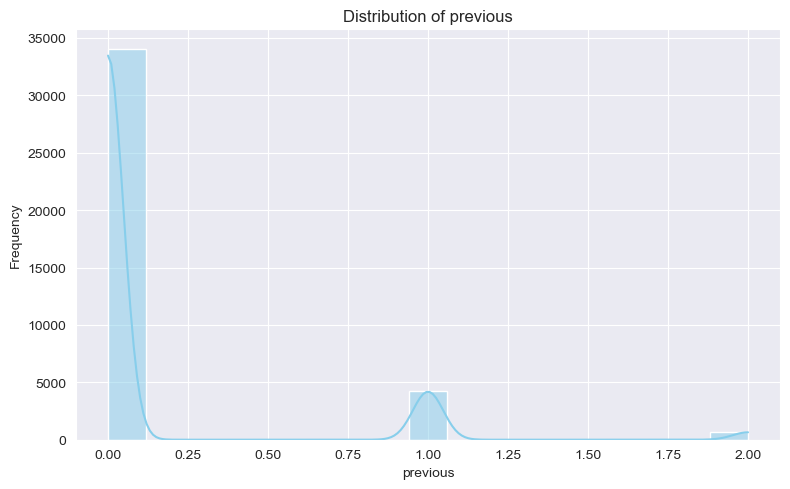

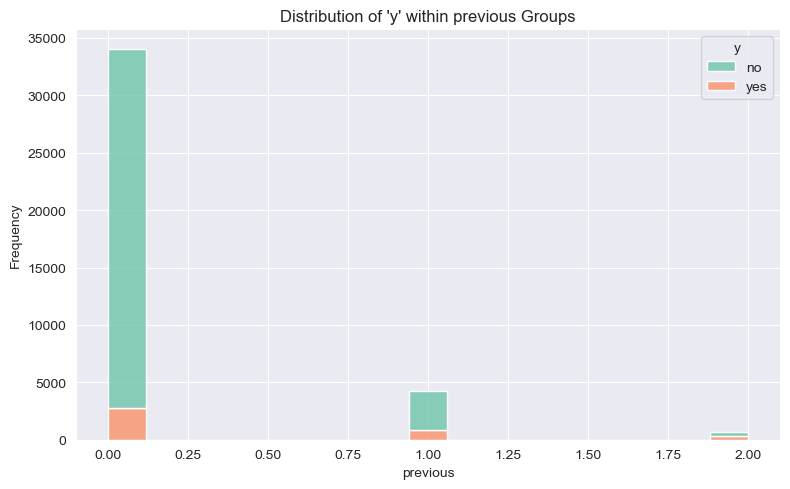

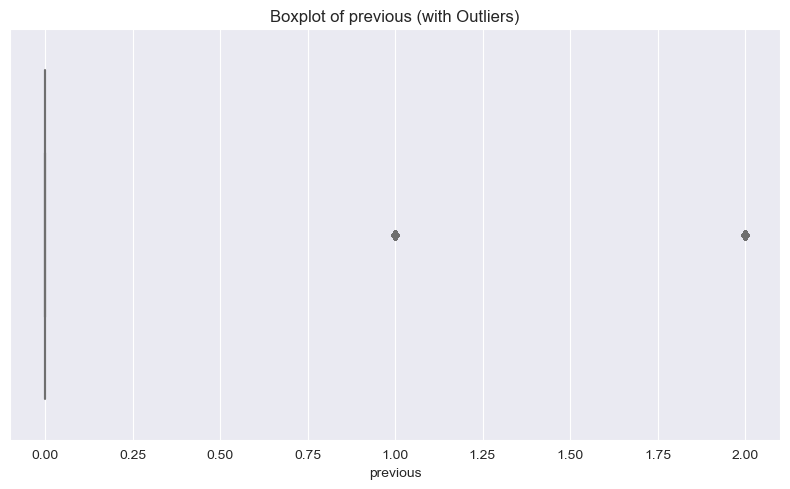

In [457]:
remove_outliers_by_quantiles(dataset_copy,'previous')
visualize(dataset_copy,'previous')

##### 6-) "emp.var.rate"

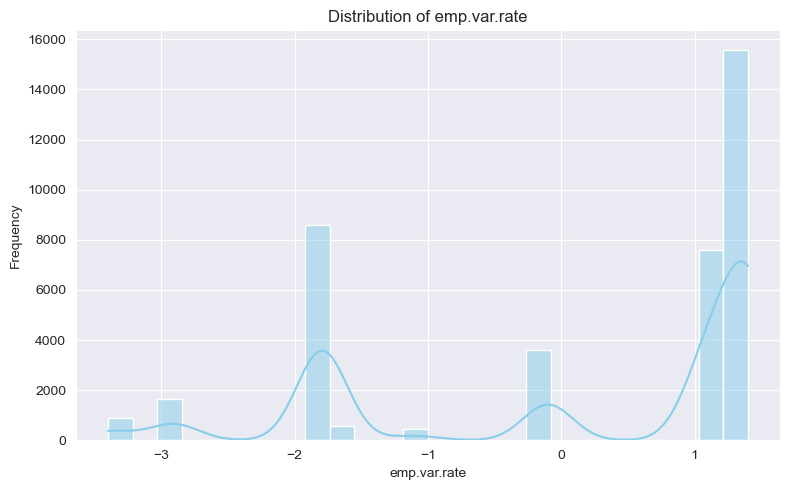

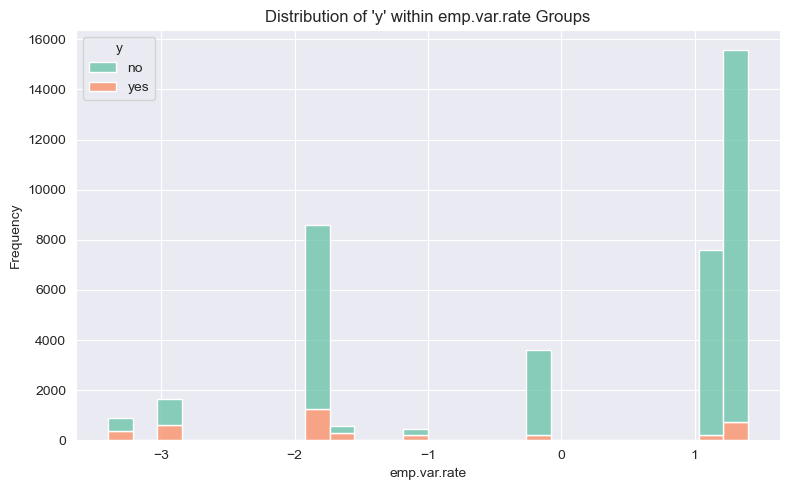

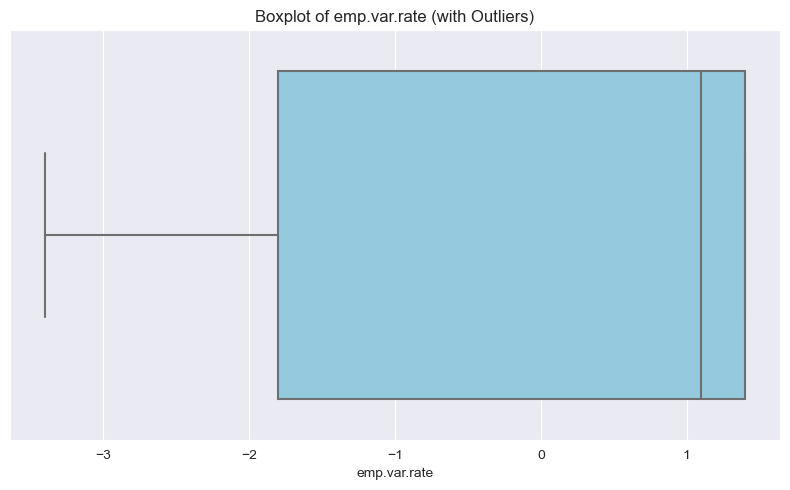

In [459]:
visualize(dataset_copy,'emp.var.rate')

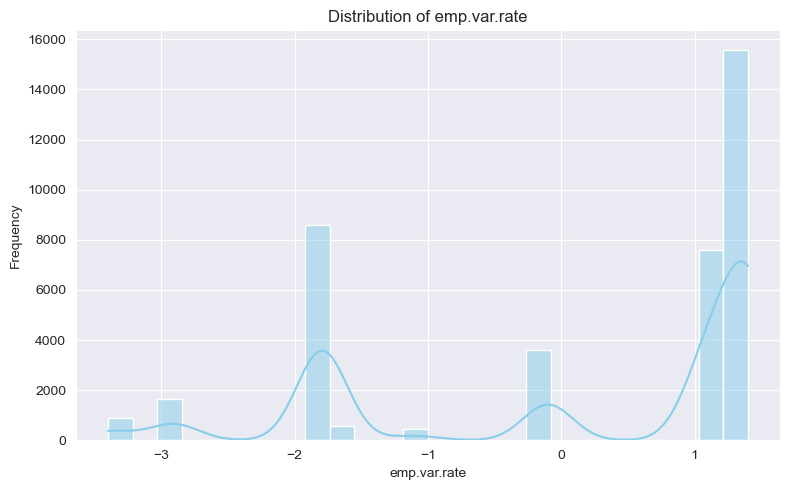

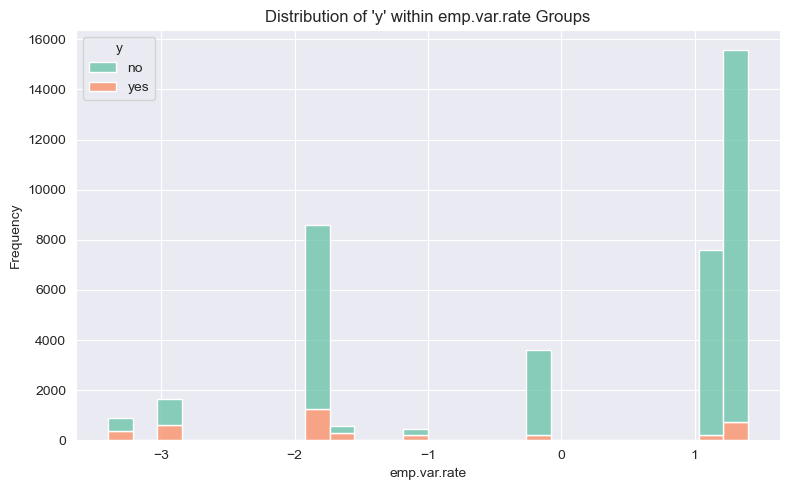

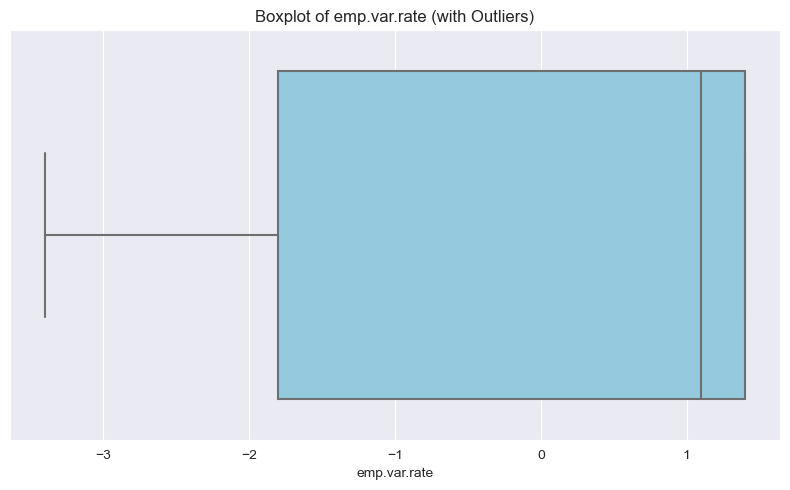

In [460]:
remove_outliers_by_quantiles(dataset_copy,'emp.var.rate')
visualize(dataset_copy,'emp.var.rate')

In [462]:
dataset_copy['emp.var.rate_sign'] = dataset_copy['emp.var.rate']
dataset_copy.loc[dataset_copy['emp.var.rate'] < 0, 'emp.var.rate_sign'] = -1    # negative employment variation rate
dataset_copy.loc[dataset_copy['emp.var.rate'] > 0, 'emp.var.rate_sign'] = 1     # positive employment variation rate

In [463]:
dataset_copy['emp.var.rate_sign'].value_counts()

emp.var.rate_sign
 1.0    23171
-1.0    15783
Name: count, dtype: int64

##### 7-) "cons.price.idx"

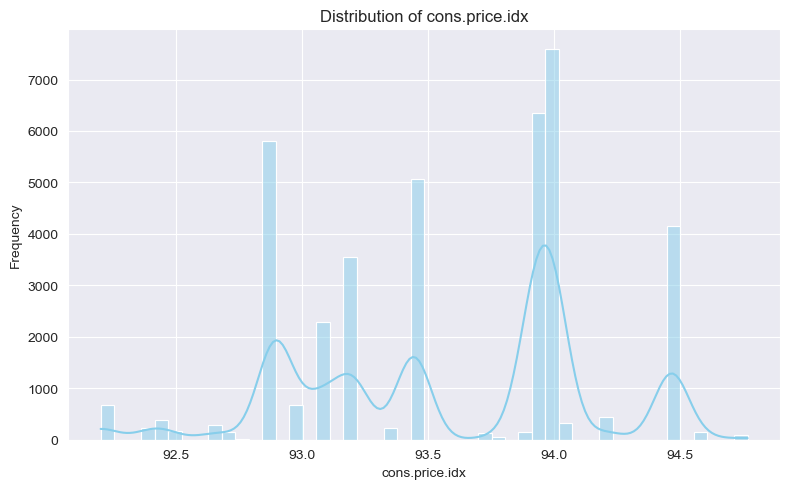

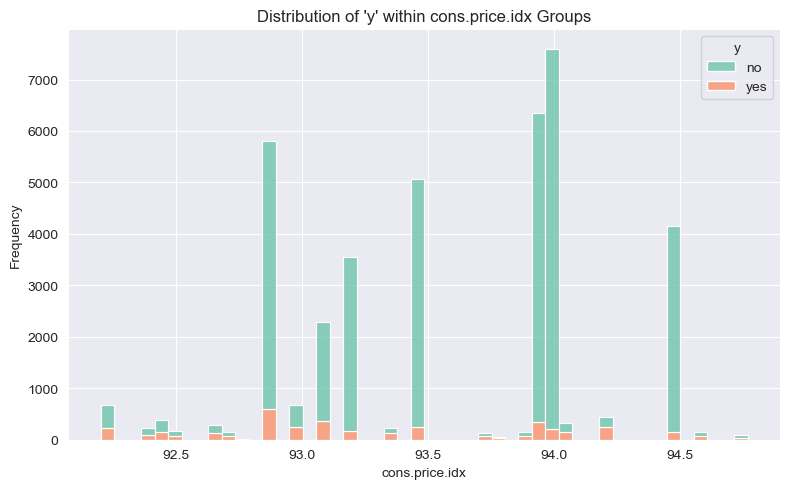

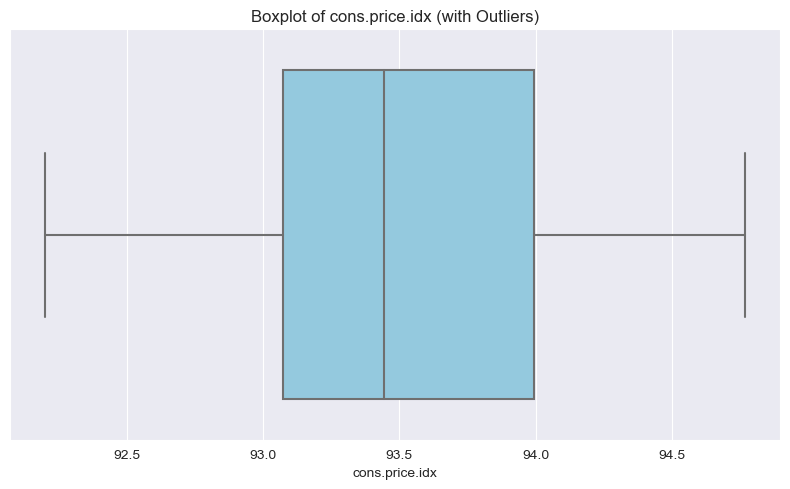

In [464]:
visualize(dataset_copy,'cons.price.idx')

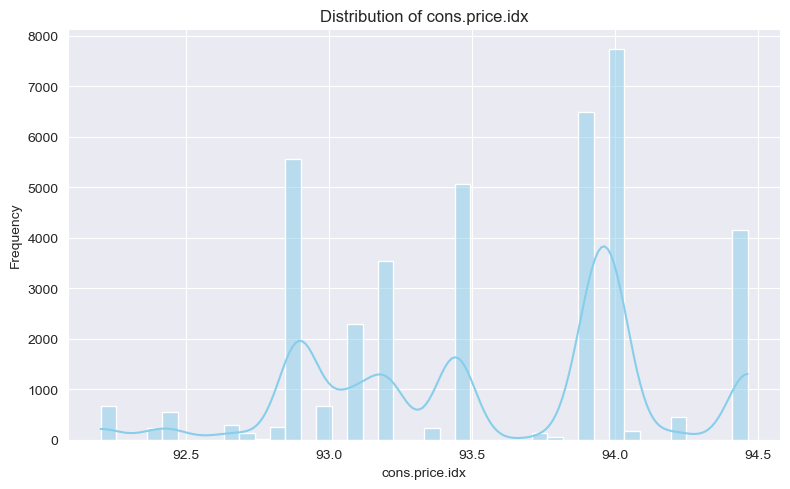

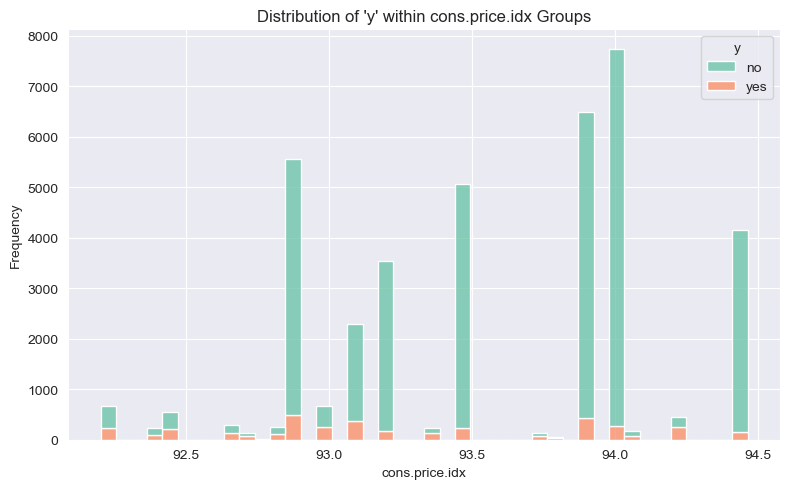

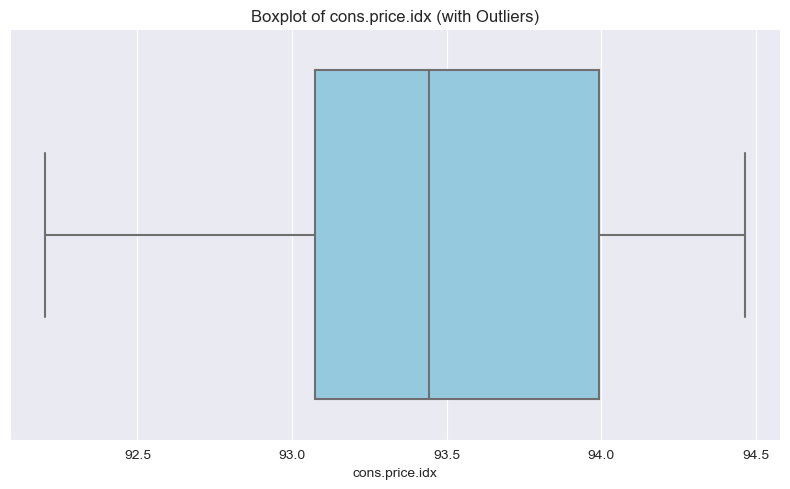

In [465]:
remove_outliers_by_quantiles(dataset_copy,'cons.price.idx')
visualize(dataset_copy,'cons.price.idx')

In [471]:
dataset_copy['cons.price.idx'].value_counts()

cons.price.idx
93.994    7594
93.918    6355
92.893    5567
93.444    5072
94.465    4150
93.200    3550
93.075    2289
92.963     674
92.201     669
92.431     375
92.649     291
92.843     247
94.215     237
92.379     232
93.369     228
94.199     204
92.469     173
94.055     172
94.027     147
92.713     142
93.876     141
93.749     136
93.798      60
92.756      10
Name: count, dtype: int64

In [472]:
cons_price_idx_threshold = generate_threshold(dataset_copy,'cons.price.idx',0.5)
print(cons_price_idx_threshold)

[92.0, 92.5, 93.0, 93.5, 94.0, 94.5]


In [473]:
print_extract_feature_by_thresholds(dataset_copy,'cons.price.idx',cons_price_idx_threshold)

(92.0_92.5] = 0.0374, samples:1449
(92.5_93.0] = 0.179, samples:6931
(93.0_93.5] = 0.2877, samples:11139
(93.5_94.0] = 0.369, samples:14286
(94.0_94.5] = 0.1268, samples:4910


In [474]:
extract_feature_by_thresholds(dataset_copy,'cons.price.idx',cons_price_idx_threshold)

In [475]:
dataset_copy['cons.price.idx_group'].value_counts()

cons.price.idx_group
cons.price.idx_(93.5_94.0]    14286
cons.price.idx_(93.0_93.5]    11139
cons.price.idx_(92.5_93.0]     6931
cons.price.idx_(94.0_94.5]     4910
cons.price.idx_(92.0_92.5]     1449
Name: count, dtype: int64

##### 8-) "cons.conf.idx"

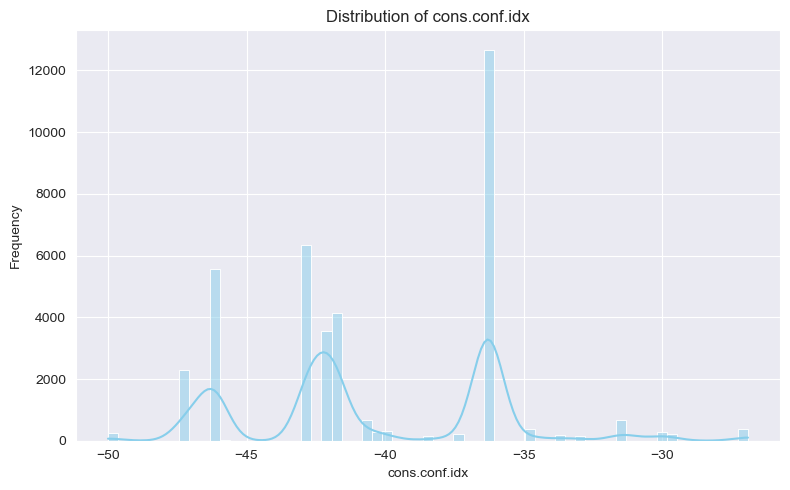

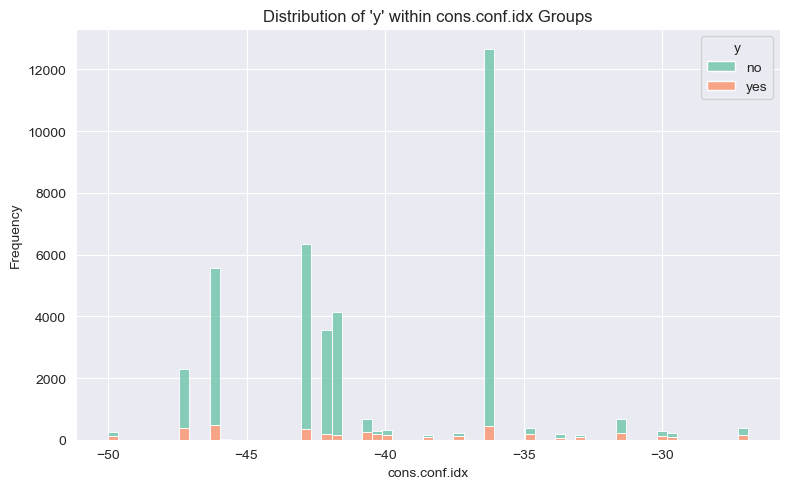

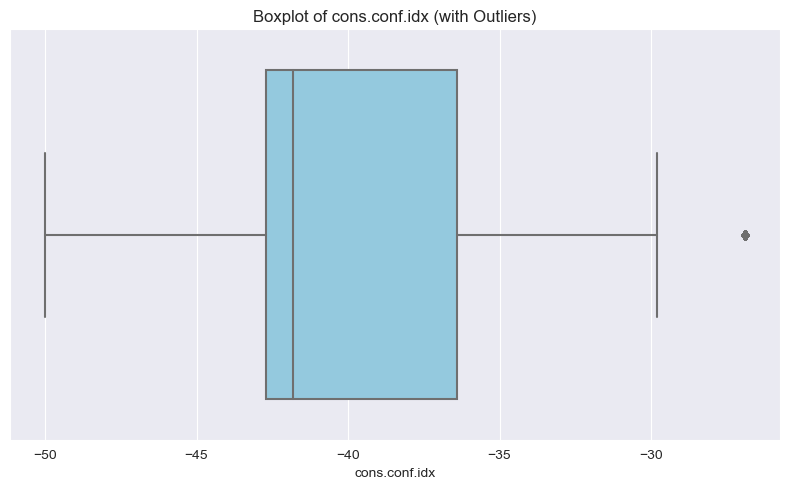

In [476]:
visualize(dataset_copy,'cons.conf.idx')

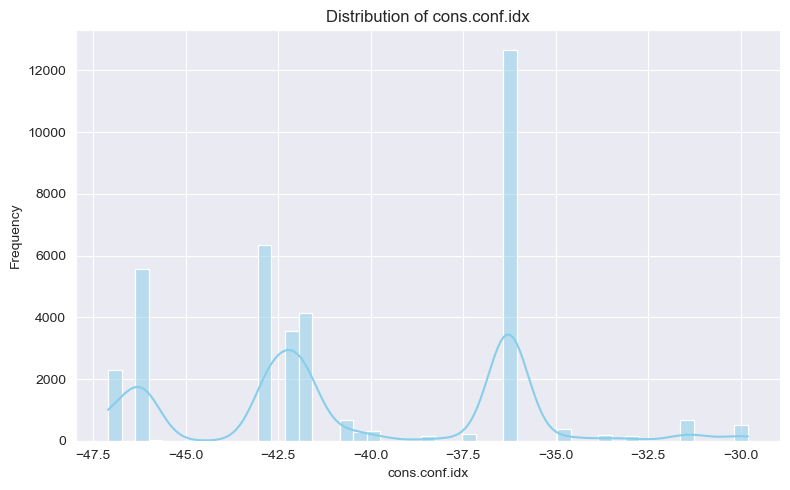

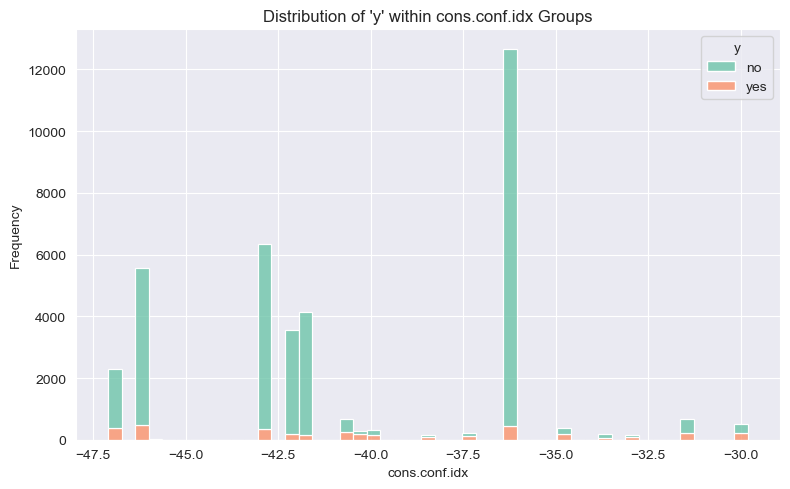

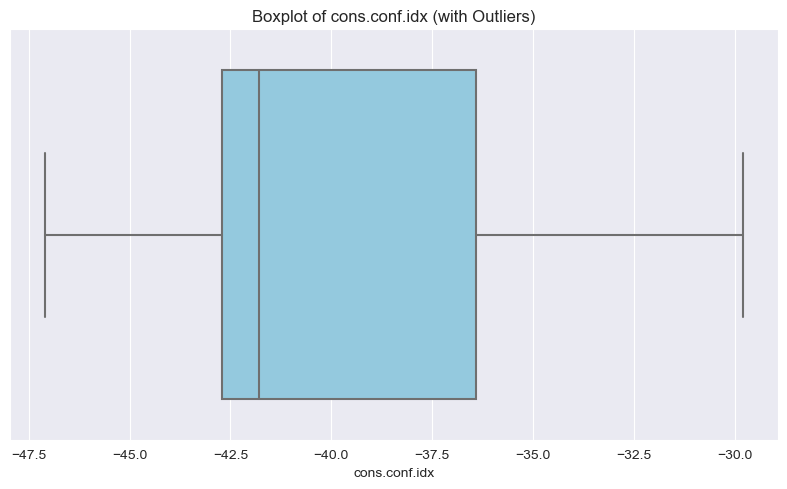

In [477]:
remove_outliers_by_quantiles(dataset_copy,'cons.conf.idx')
visualize(dataset_copy,'cons.conf.idx')

In [486]:
cons_conf_idx_threshold = generate_threshold(dataset_copy,'cons.conf.idx',5)
print(cons_conf_idx_threshold)

[-50.0, -45.0, -40.0, -35.0, -30.0, -25.0]


In [487]:
print_extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

(-50.0_-45.0] = 0.2065, samples:7866
(-45.0_-40.0] = 0.3982, samples:15167
(-40.0_-35.0] = 0.3462, samples:13189
(-35.0_-30.0] = 0.043, samples:1639
(-30.0_-25.0] = 0.0061, samples:232


In [488]:
extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

In [489]:
dataset_copy['cons.price.idx_group'].value_counts()

cons.price.idx_group
cons.price.idx_(93.5_94.0]    14286
cons.price.idx_(93.0_93.5]    11139
cons.price.idx_(92.5_93.0]     6684
cons.price.idx_(94.0_94.5]     4910
cons.price.idx_(92.0_92.5]     1074
Name: count, dtype: int64

##### 9-) "euribor3m"

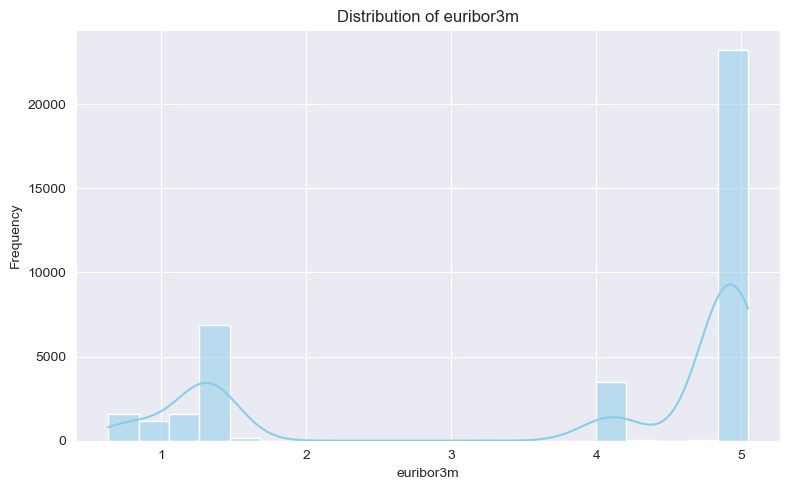

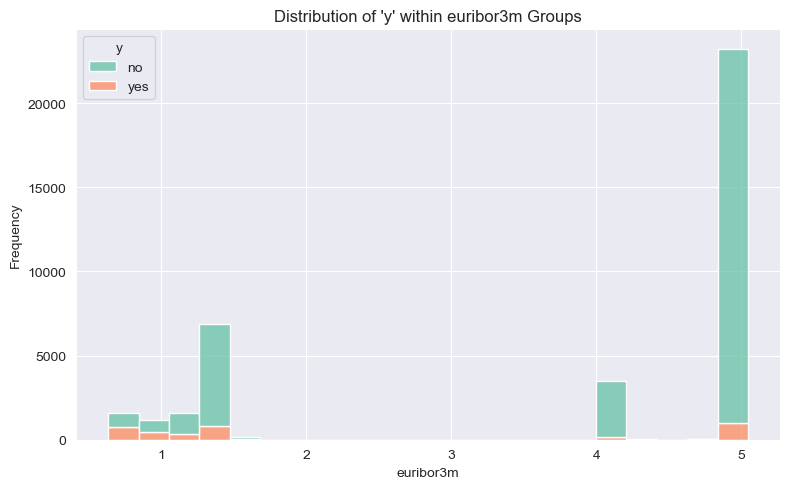

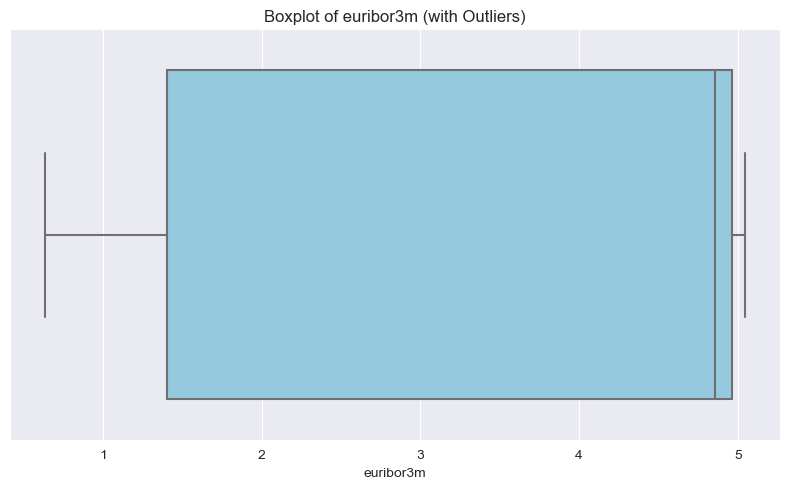

In [490]:
visualize(dataset_copy,'euribor3m')

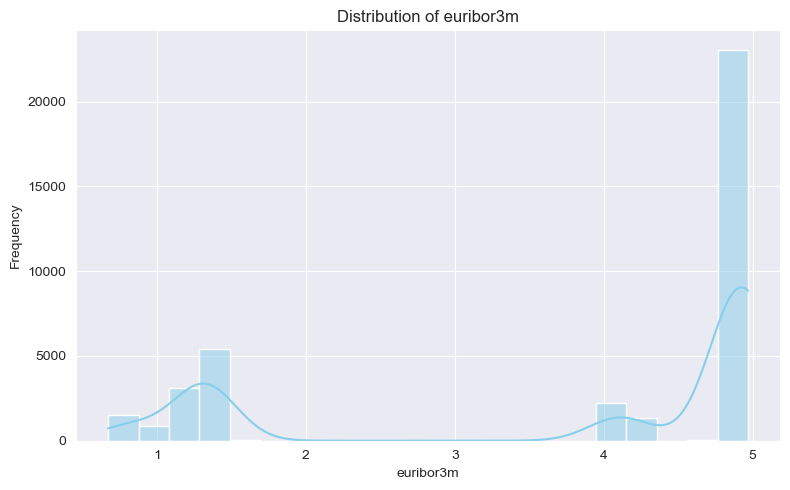

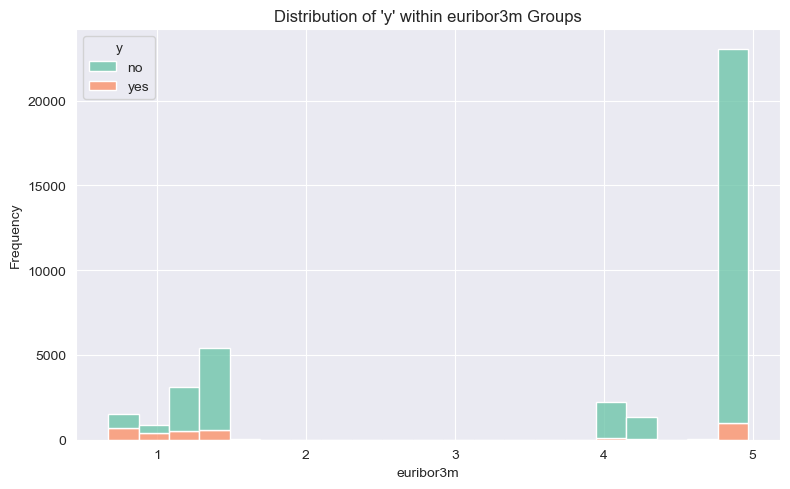

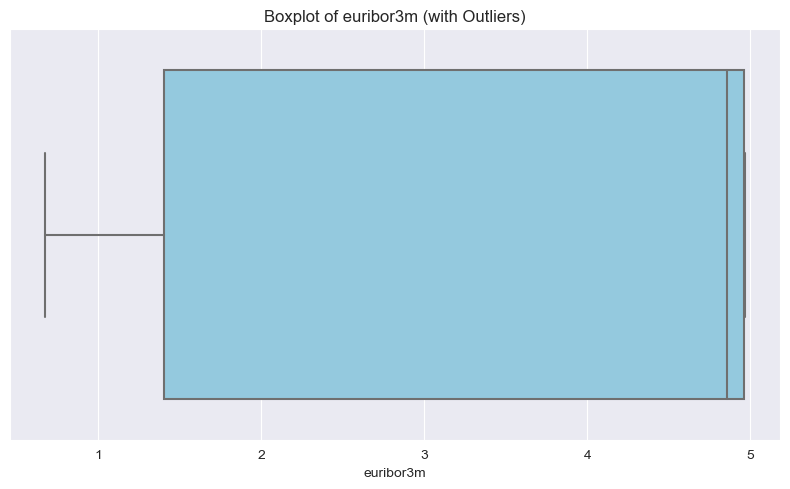

In [491]:
remove_outliers_by_quantiles(dataset_copy,'euribor3m')
visualize(dataset_copy,'euribor3m')

##### 10-) "nr.employed"

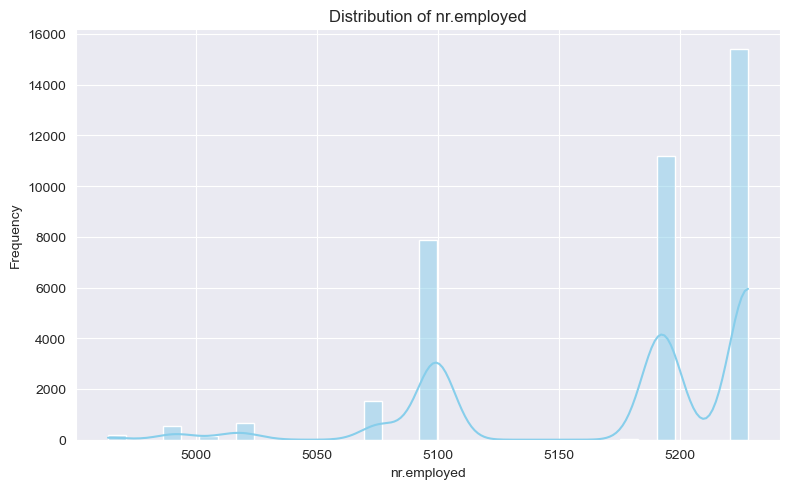

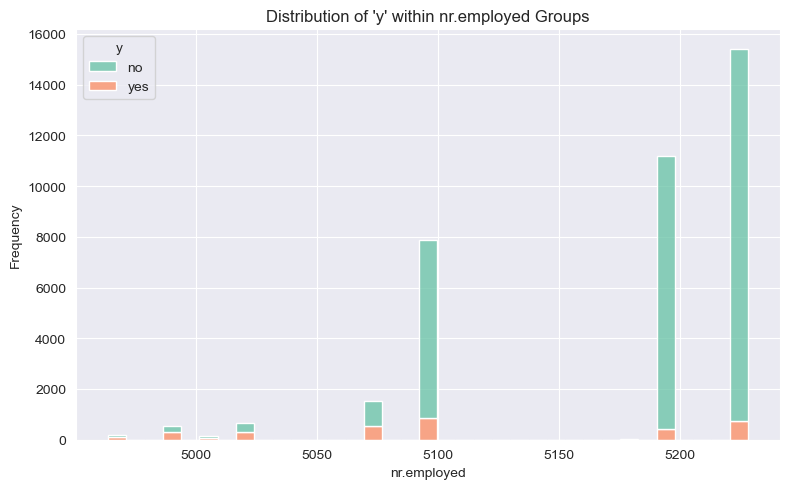

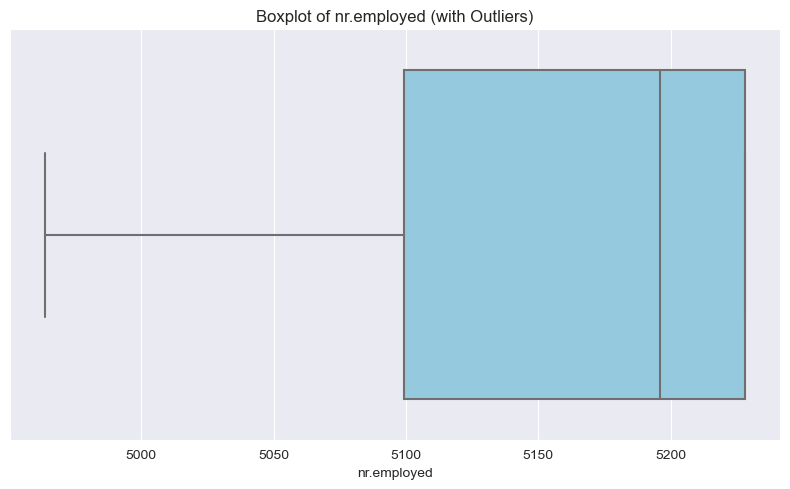

In [500]:
visualize(dataset_copy,'nr.employed')

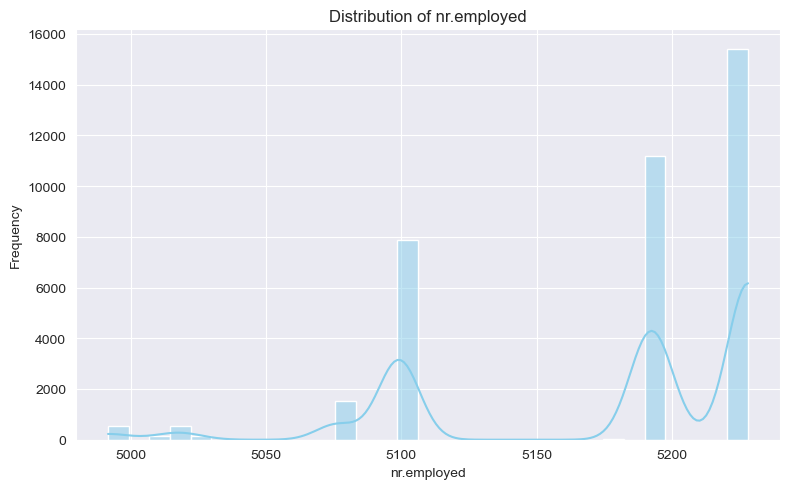

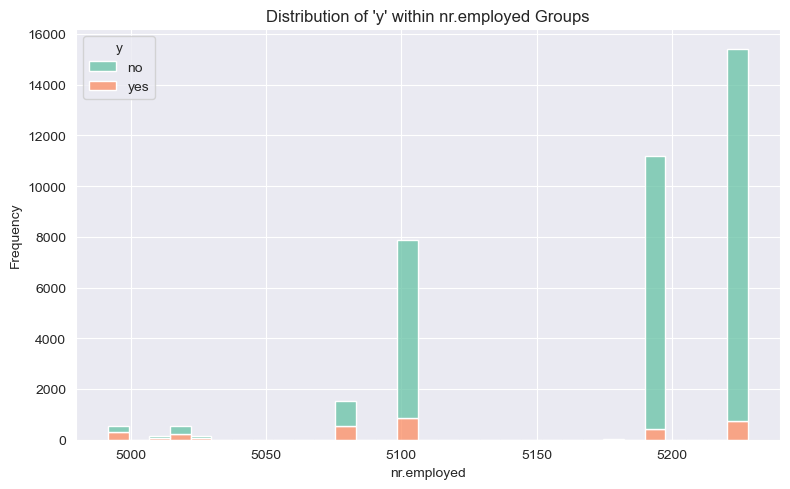

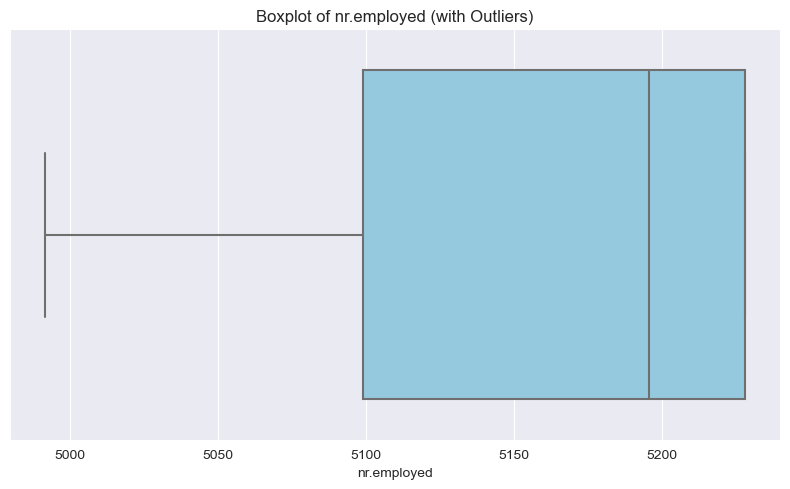

In [501]:
remove_outliers_by_quantiles(dataset_copy,'nr.employed')
visualize(dataset_copy,'nr.employed')

In [502]:
dataset_copy['nr.employed'].value_counts()

nr.employed
5228.1    15406
5099.1     7856
5191.0     7594
5195.8     3597
5076.2     1516
4991.6      556
5017.5      523
5023.5      142
5008.7      130
5176.3       10
Name: count, dtype: int64

In [511]:
nr_employed_threshold = generate_threshold(dataset_copy, 'nr.employed', 100)
print(nr_employed_threshold)

[4900.0, 5000.0, 5100.0, 5200.0, 5300.0]


In [512]:
print_extract_feature_by_thresholds(dataset_copy, 'nr.employed', nr_employed_threshold)

(4900.0_5000.0] = 0.0149, samples:556
(5000.0_5100.0] = 0.2724, samples:10167
(5100.0_5200.0] = 0.3001, samples:11201
(5200.0_5300.0] = 0.4127, samples:15406


In [513]:
extract_feature_by_thresholds(dataset_copy, 'nr.employed', nr_employed_threshold)

<Axes: >

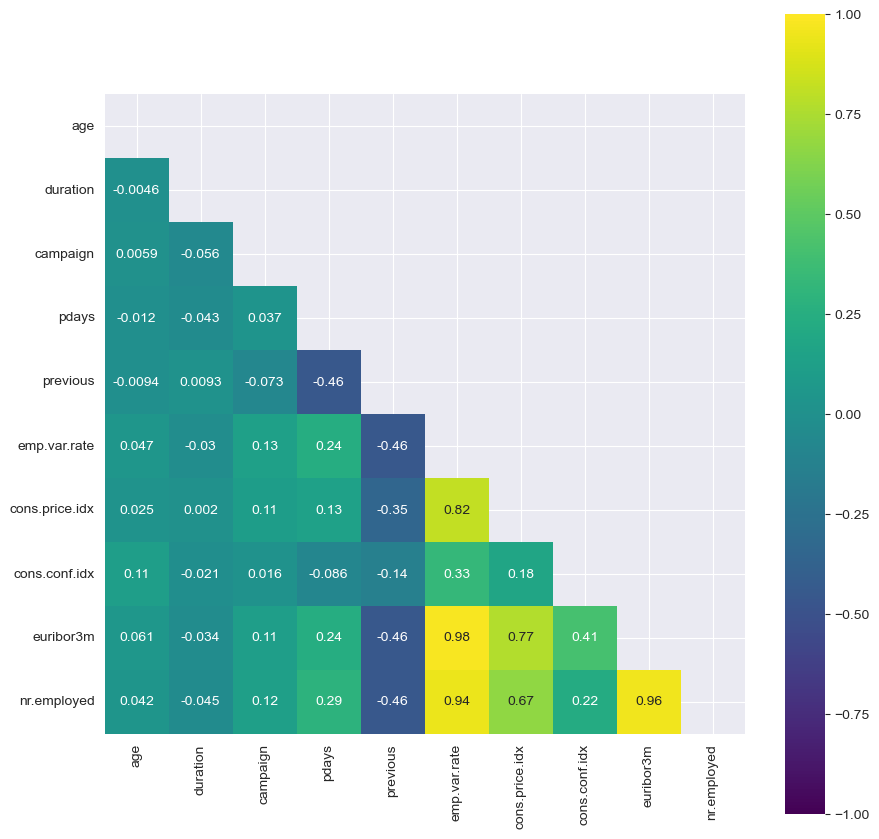

In [540]:
corr_data_columns = dataset_copy.columns[0:10]
## taking from https://github.com/bowcai/bank-analysis/blob/main/bank-analysis.ipynb
fig= plt.figure(figsize=(8,8))

corr = dataset_copy[corr_data_columns].corr()
mask = np.triu(dataset_copy[corr_data_columns].corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [544]:
dataset_copy.select_dtypes(include=['category']).columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')